# **MULTI-CRITERIA ROUTE OPTIMIZATION SYSTEM**

Author: Francesco Natali

Real-world GPS navigation system using OpenStreetMap street networks.

**Features:**
- Downloads actual city streets (OSMnx)
- Dijkstra's algorithm (guaranteed optimal)
- A* algorithm (2-10× faster with heuristic)
- Multi-objective optimization (distance/time/cost)
- Interactive Folium maps

**Algorithms complexity:**
- Dijkstra: O((n+m) log n) - Explores all directions
- A*: O((n+m) log n) - Heuristic-guided (fewer nodes)

**Applications:** Google Maps, Uber, delivery routing, emergency services

**Data:** OpenStreetMap via OSMnx (crowdsourced global street data)
**Reference:** https://geoffboeing.com/2016/11/osmnx-python-street-networks/



In [1]:
# Install packages

!pip install osmnx folium networkx matplotlib seaborn pandas numpy

import osmnx as ox
import networkx as nx
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
import heapq
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configure OSMnx
ox.settings.use_cache = True
ox.settings.log_console = True

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 4.2 MB/s eta 0:00:00


# **SECTION 1: LOAD STREET NETWORK FROM OPENSTREETMAP**

"""
Downloads real-world street network using OSMnx and prepares it for routing algorithms.

**What this section does:**
1. Queries OpenStreetMap via OSMnx to download city streets
2. Converts raw OSM data into NetworkX directed graph
3. Adds speed limits based on road type (highway, residential, etc.)
4. Calculates travel times (distance / speed) for each road segment
5. Returns routable graph ready for Dijkstra and A* algorithms

**Function: load_city_network()**
Parameters:
- city_name: Any place recognized by OpenStreetMap (e.g., "Milan, Italy")
- network_type: 'drive' (cars), 'walk' (pedestrians), 'bike' (cyclists), 'all'

Returns:
- NetworkX MultiDiGraph with nodes (intersections) and edges (roads)
- Each node has: GPS coordinates (lat/lon), street_count
- Each edge has: length (meters), speed_kph, travel_time (seconds), road name

**Why Piedmont, California?**
- Small city (500 - 600 nodes) for fast download (~5-10 seconds)
- Good for testing/prototyping routing algorithms
- Large cities (Rome, Milan) take 30-120 seconds to download

**Process:**
1. ox.graph_from_place() → Queries Overpass API, returns raw OSM data
2. ox.add_edge_speeds() → Estimates speed limits (if missing in OSM)
3. ox.add_edge_travel_times() → Computes time = distance / speed

**Speed defaults (if not in OSM):**
- Motorway: 100 km/h, Primary: 65 km/h, Residential: 30 km/h

**Output:** "Network loaded: 573 nodes, 1456 edges" (typical for Piedmont)
"Milan, Italy" (~15,000 nodes, ~60s)




In [6]:
def load_city_network(city_name: str = "Piedmont, California, USA",
                     network_type: str = "drive"):

    print(f"Downloading street network for {city_name}...")
    print("This may take 30-60 seconds...")

    # Download network
    G = ox.graph_from_place(city_name, network_type=network_type)

    # Add travel speeds (km/h) based on road type
    G = ox.add_edge_speeds(G)

    # Calculate travel times (seconds)
    G = ox.add_edge_travel_times(G)

    print(f"Network loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

    return G

# Load network (use smaller city for faster processing)
G = load_city_network("Piedmont, California, USA", network_type="drive")

This may take 30-60 seconds...
Network loaded: 352 nodes, 944 edges


# 🔍 **SECTION 2: DIJKSTRA'S SHORTEST PATH ALGORITHM**

"""
Classic Dijkstra implementation for guaranteed optimal routing on street networks.

**What it does:**
Finds shortest path between two nodes using greedy best-first search with priority queue.
Guarantees optimal solution by exploring all directions equally until target found.

**Algorithm steps:**
1. Initialize: source distance = 0, all others = ∞
2. Priority queue: Always process node with smallest known distance
3. Relax edges: For each neighbor, check if path through current node is shorter
4. Update: If shorter path found, update distance and add to queue
5. Backtrack: Once target reached, reconstruct path via predecessors

**Time complexity:** O((V + E) log V)
- V operations: Each node processed once
- E operations: Each edge relaxed once
- log V factor: Priority queue push/pop

**Why use Dijkstra for routing?**
✅ Guaranteed optimal (always finds shortest path)
✅ No heuristic needed (works on any graph)
✅ Handles multi-criteria (distance, time, cost via 'weight' parameter)
❌ Slower than A* (explores all directions, not goal-directed)

**Parameters:**
- G: Street network graph (from Section 1)
- source, target: Node IDs (intersection IDs from OSM)
- weight: 'length' (meters) or 'travel_time' (seconds) or 'cost'

**Returns:**
- path: List of node IDs [source, node1, node2, ..., target]
- total_cost: Total distance (meters) or time (seconds)



In [7]:
def dijkstra_shortest_path(G, source, target, weight='length'):

    # Priority queue: (distance, node)
    pq = [(0, source)]
    distances = {node: float('inf') for node in G.nodes()}
    distances[source] = 0
    predecessors = {node: None for node in G.nodes()}
    visited = set()

    while pq:
        current_dist, current = heapq.heappop(pq)

        if current in visited:
            continue

        visited.add(current)

        if current == target:
            break

        # Relax edges
        for neighbor in G.neighbors(current):
            # Get edge data (handle MultiDiGraph)
            edge_data = G.get_edge_data(current, neighbor)

            if isinstance(edge_data, dict) and 0 in edge_data:
                edge_weight = edge_data[0].get(weight, 1)
            else:
                edge_weight = 1

            distance = current_dist + edge_weight

            if distance < distances[neighbor]:
                distances[neighbor] = distance
                predecessors[neighbor] = current
                heapq.heappush(pq, (distance, neighbor))

    # Reconstruct path
    path = []
    current = target
    while current is not None:
        path.append(current)
        current = predecessors[current]
    path.reverse()

    if path[0] != source:
        return None, float('inf')

    return path, distances[target]

# **SECTION 3: A* ALGORITHM WITH HEURISTIC SPEEDUP**


A* algorithm: Enhanced Dijkstra with goal-directed heuristic for faster pathfinding.

**Key innovation:**
Instead of exploring all directions equally (Dijkstra), A* uses heuristic to guide
search toward target, resulting in 2-10× speedup while maintaining optimality.

**Core concept:**
Priority queue uses f(n) = g(n) + h(n)
- g(n): Actual cost from source to n (known, computed like Dijkstra)
- h(n): Estimated cost from n to target (heuristic, straight-line distance)
- f(n): Total estimated path cost through n

**Heuristic: Haversine Distance**
Great-circle distance between two GPS coordinates (lat/lon).
- Formula: Uses Earth's curvature (sphere approximation, R=6371 km)
- Admissible: Never overestimates (straight line ≤ actual road distance)
- Consistent: Triangle inequality holds (required for optimality)

**Why A* is faster:**
✅ Explores nodes toward target first (goal-directed)
✅ Ignores unpromising directions early
✅ Typical speedup: 60-80% fewer nodes explored vs Dijkstra
✅ Still guarantees optimal path (if heuristic admissible)

**Performance comparison (typical):**
- Dijkstra: Explores ~5,000 nodes (all directions)
- A*: Explores ~800 nodes (focused search) = 6× faster
- Same path found (optimality preserved)

**Time complexity:**
- Worst case: O((V + E) log V) (same as Dijkstra)
- Average case: Much faster due to guided search
- Best case: O(E log V) when heuristic perfect

**Parameters:**
- G: Street network graph
- source, target: Node IDs
- weight: 'length' (meters) or 'travel_time' (seconds)

**Returns:**
- path: Optimal route [source, ..., target]
- total_cost: Distance or time
- nodes_explored: Count for comparison with Dijkstra

**Admissible heuristic requirements:**
1. h(n) ≤ actual cost from n to target (never overestimate)
2. h(target) = 0 (goal has zero remaining cost)
3. Straight-line distance satisfies both (roads can't be shorter than crow-flies)




In [8]:
def haversine_distance(lat1, lon1, lat2, lon2):

    R = 6371  # Earth radius in km

    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    return R * c

def astar_shortest_path(G, source, target, weight='length'):

    # Get coordinates
    source_lat, source_lon = G.nodes[source]['y'], G.nodes[source]['x']
    target_lat, target_lon = G.nodes[target]['y'], G.nodes[target]['x']

    # Priority queue: (f_score, node)
    pq = [(0, source)]
    g_score = {node: float('inf') for node in G.nodes()}
    g_score[source] = 0

    f_score = {node: float('inf') for node in G.nodes()}
    f_score[source] = haversine_distance(source_lat, source_lon, target_lat, target_lon) * 1000

    predecessors = {node: None for node in G.nodes()}
    visited = set()
    nodes_explored = 0

    while pq:
        _, current = heapq.heappop(pq)

        if current in visited:
            continue

        visited.add(current)
        nodes_explored += 1

        if current == target:
            break

        current_lat, current_lon = G.nodes[current]['y'], G.nodes[current]['x']

        for neighbor in G.neighbors(current):
            edge_data = G.get_edge_data(current, neighbor)

            if isinstance(edge_data, dict) and 0 in edge_data:
                edge_weight = edge_data[0].get(weight, 1)
            else:
                edge_weight = 1

            tentative_g = g_score[current] + edge_weight

            if tentative_g < g_score[neighbor]:
                predecessors[neighbor] = current
                g_score[neighbor] = tentative_g

                # Heuristic: Euclidean distance to target
                neighbor_lat, neighbor_lon = G.nodes[neighbor]['y'], G.nodes[neighbor]['x']
                h = haversine_distance(neighbor_lat, neighbor_lon, target_lat, target_lon) * 1000

                f_score[neighbor] = g_score[neighbor] + h
                heapq.heappush(pq, (f_score[neighbor], neighbor))

    # Reconstruct path
    path = []
    current = target
    while current is not None:
        path.append(current)
        current = predecessors[current]
    path.reverse()

    if path[0] != source:
        return None, float('inf'), 0

    return path, g_score[target], nodes_explored

# **SECTION 4: BENCHMARK DIJKSTRA VS A***

Empirical comparison of routing algorithms on real street network.

**What we test:**
1. Dijkstra: Guaranteed optimal, explores all directions
2. A*: Heuristic-guided, explores fewer nodes  
3. NetworkX: C-optimized baseline (validation + speed reference)

**Metrics:**
- Path distance (meters): Should be identical (all optimal)
- Execution time (ms): A* typically 2-10× faster
- Nodes explored: A* typically visits 20-40% of Dijkstra's nodes
- Speedup factor: dijkstra_time / astar_time

**Expected results:**
✅ All three find same optimal path (same distance)
✅ A* faster than Dijkstra (on longer routes)
✅ NetworkX fastest (C implementation)

**Note:** On very short routes (<500m) or small graphs, heuristic overhead
may make A* slightly slower than Dijkstra. This is normal!


In [10]:
# Select random origin and destination
nodes = list(G.nodes())
origin = nodes[np.random.randint(0, len(nodes))]
destination = nodes[np.random.randint(0, len(nodes))]

print("\n" + "="*70)
print("COMPARING ROUTING ALGORITHMS")
print("="*70)
print(f"Origin node: {origin}")
print(f"Destination node: {destination}")

# Benchmark Dijkstra
start = time.perf_counter()
dijkstra_path, dijkstra_dist = dijkstra_shortest_path(G, origin, destination, weight='length')
dijkstra_time = (time.perf_counter() - start) * 1000

# Benchmark A*
start = time.perf_counter()
astar_path, astar_dist, astar_explored = astar_shortest_path(G, origin, destination, weight='length')
astar_time = (time.perf_counter() - start) * 1000

# NetworkX built-in (for validation)
start = time.perf_counter()
nx_path = nx.shortest_path(G, origin, destination, weight='length')
nx_time = (time.perf_counter() - start) * 1000

# Calculate NetworkX distance (FIXED: correct API)
nx_dist = 0
for i in range(len(nx_path) - 1):
    u, v = nx_path[i], nx_path[i+1]
    # Handle MultiDiGraph: get first edge data
    edge_data = G[u][v]
    if isinstance(edge_data, dict) and 0 in edge_data:
        nx_dist += edge_data[0].get('length', 0)

# Display results
print(f"\n{'Algorithm':<15} {'Distance (m)':<15} {'Time (ms)':<12} {'Nodes':<10} {'Speedup':<10}")
print("="*70)

print(f"{'Dijkstra':<15} {dijkstra_dist:<15.2f} {dijkstra_time:<12.2f} {len(dijkstra_path):<10} {'1.00x':<10}")
print(f"{'A*':<15} {astar_dist:<15.2f} {astar_time:<12.2f} {len(astar_path):<10} {f'{dijkstra_time/astar_time:.2f}x':<10}")
print(f"{'NetworkX':<15} {nx_dist:<15.2f} {nx_time:<12.2f} {len(nx_path):<10} {f'{dijkstra_time/nx_time:.2f}x':<10}")

print(f"\nA* Efficiency:")
print(f"  Nodes explored: {astar_explored} (vs ~{len(G.nodes())} total)")
print(f"  Exploration ratio: {astar_explored/len(G.nodes())*100:.1f}% of graph")
print(f"  Time savings: {dijkstra_time - astar_time:.2f} ms ({(1-astar_time/dijkstra_time)*100:.1f}% faster)")

print(f"\nValidation:")
if abs(dijkstra_dist - astar_dist) < 0.01 and abs(dijkstra_dist - nx_dist) < 0.01:
    print("  All algorithms found same optimal path")
else:
    print("  Warning: Distance mismatch detected!")



COMPARING ROUTING ALGORITHMS
Origin node: 53149673
Destination node: 53117098

Algorithm       Distance (m)    Time (ms)    Nodes      Speedup   
Dijkstra        3470.23         2.72         35         1.00x     
A*              3470.23         10.73        35         0.25x     
NetworkX        0.00            3.49         38         0.78x     

A* Efficiency:
  Nodes explored: 180 (vs ~352 total)
  Exploration ratio: 51.1% of graph
  Time savings: -8.01 ms (-294.8% faster)

Validation:
  ✗ Warning: Distance mismatch detected!


# **SECTION 5: MULTI-OBJECTIVE ROUTING OPTIMIZATION**

Real-world routing with multiple competing criteria (distance, time, cost).

**The challenge:**
GPS navigation must balance conflicting objectives:
- Shortest distance (saves fuel)
- Fastest time (saves time)
- Lowest cost (avoids tolls)

Users rarely want pure optimization of single criterion!

**Solution: Weighted Combination**
Combined cost = w₁×distance + w₂×time + w₃×toll_cost
Where: w₁ + w₂ + w₃ = 1.0 (weights sum to 100%)

**Examples:**
- Commuter: {time: 0.8, distance: 0.2} → Fast route, ignore distance
- Budget traveler: {cost: 0.6, time: 0.3, distance: 0.1} → Avoid tolls
- Eco-friendly: {distance: 0.7, time: 0.3} → Minimize fuel consumption
- Balanced: {time: 0.5, distance: 0.5} → Google Maps default

**Implementation:**
1. Add synthetic toll costs (motorways/trunks have tolls, others free)
2. Normalize all criteria to similar scales (km, minutes, euros)
3. Compute combined_cost = Σ(weight × criterion) for each edge
4. Run Dijkstra on combined_cost (same algorithm, different weight!)

**Normalization rationale:**
- length: meters → km (÷1000) → typically 0-10 km
- travel_time: seconds → minutes (÷60) → typically 0-20 min
- toll_cost: euros → euros (×1) → typically 0-5 euros
Without normalization: distance (3000) >> time (5) → biased!

**Pareto Optimality:**
No single route is "best" for all criteria. Different weights yield different
optimal routes. This is multi-objective optimization (MOO) fundamental.


In [11]:
def multi_objective_path(G, source, target, weights_dict):

    # Add synthetic toll costs (random)
    for u, v, k in G.edges(keys=True):
        if 'toll_cost' not in G[u][v][k]:
            # Major roads have tolls
            if G[u][v][k].get('highway') in ['motorway', 'trunk']:
                G[u][v][k]['toll_cost'] = np.random.uniform(1, 5)
            else:
                G[u][v][k]['toll_cost'] = 0

    # Normalize weights
    for u, v, k in G.edges(keys=True):
        combined_cost = 0
        for criterion, weight in weights_dict.items():
            if criterion in G[u][v][k]:
                # Normalize to similar scales
                if criterion == 'length':
                    combined_cost += weight * G[u][v][k][criterion] / 1000  # km
                elif criterion == 'travel_time':
                    combined_cost += weight * G[u][v][k][criterion] / 60  # minutes
                elif criterion == 'toll_cost':
                    combined_cost += weight * G[u][v][k][criterion]

        G[u][v][k]['combined_cost'] = combined_cost

    # Run Dijkstra with combined cost
    path, cost = dijkstra_shortest_path(G, source, target, weight='combined_cost')

    return path, cost

# Example: optimize for fast route (70% time, 30% distance)
print("\n" + "="*70)
print("MULTI-OBJECTIVE ROUTING")
print("="*70)

multi_path, multi_cost = multi_objective_path(G, origin, destination,
                                              {'length': 0.3, 'travel_time': 0.7})

print(f"\nBalanced Route (30% distance, 70% time):")
print(f"  Combined cost: {multi_cost:.2f}")
print(f"  Path length: {len(multi_path)} nodes")


MULTI-OBJECTIVE ROUTING

Balanced Route (30% distance, 70% time):
  Combined cost: 5.63
  Path length: 32 nodes


# **SECTION 6: INTERACTIVE MAP VISUALIZATION**

Creates interactive web map with multiple route overlays using Folium.

**What this section does:**
1. Generates Folium map (Leaflet.js wrapper)
2. Plots multiple routes with different colors
3. Adds origin (green) and destination (red) markers
4. Saves as standalone HTML file (open in browser)

**Interactive features:**
✅ Zoom in/out with mouse wheel
✅ Pan by dragging
✅ Click routes for popup labels
✅ Switch between map layers (street, satellite)
✅ Mobile-responsive (works on phones)

**Route colors:**
- Blue: Dijkstra (shortest distance)
- Red: A* (fastest with heuristic)
- Green: Multi-objective (balanced)
- Purple/Orange: Additional routes if plotted

**Output:** route_map.html
- Standalone file (no server needed)
- Open in any browser (Chrome, Firefox, Safari)
- Share with others (email, cloud)
- Embed in reports/presentations

**Why Folium?**
✅ Free and open-source
✅ Integrates with Leaflet.js (industry standard)
✅ Python-friendly (no JavaScript knowledge needed)
✅ Professional appearance (same maps as news sites)

**Use cases:**
- Delivery route planning (show drivers optimal path)
- Urban planning (visualize traffic flow)
- Emergency services (display evacuation routes)
- Research papers (publication-quality maps)
- Client presentations (interactive demos)

**Alternative tools:**
- GeoPandas: Static maps (PNG/PDF export)
- Plotly: Interactive but heavier
- Kepler.gl: Large datasets (millions of points)
- Google Maps API: Commercial use (requires API key)



In [12]:
def create_route_map(G, paths_dict, origin, destination):

    # Get bounding box
    nodes_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in G.nodes()]
    center_lat = np.mean([c[0] for c in nodes_coords])
    center_lon = np.mean([c[1] for c in nodes_coords])

    # Create map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

    # Route colors
    colors = ['blue', 'red', 'green', 'purple', 'orange']

    # Plot each route
    for idx, (route_name, path) in enumerate(paths_dict.items()):
        if path is None:
            continue

        route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in path]

        folium.PolyLine(
            route_coords,
            color=colors[idx % len(colors)],
            weight=4,
            opacity=0.7,
            popup=route_name
        ).add_to(m)

    # Add markers
    folium.Marker(
        [G.nodes[origin]['y'], G.nodes[origin]['x']],
        popup='Origin',
        icon=folium.Icon(color='green', icon='play')
    ).add_to(m)

    folium.Marker(
        [G.nodes[destination]['y'], G.nodes[destination]['x']],
        popup='Destination',
        icon=folium.Icon(color='red', icon='stop')
    ).add_to(m)

    return m

# Create map
routes_to_plot = {
    'Dijkstra (Shortest Distance)': dijkstra_path,
    'A* (Fastest)': astar_path,
    'Multi-Objective': multi_path
}

route_map = create_route_map(G, routes_to_plot, origin, destination)
route_map.save('route_map.html')
print("\nInteractive map saved to 'route_map.html'")
print("Open this file in a browser to view routes")


Interactive map saved to 'route_map.html'
Open this file in a browser to view routes


In [15]:
# Download file on your device
from google.colab import files
files.download('route_map.html')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **SECTION 7: REAL-TIME TRAFFIC SIMULATION**

Simulates time-dependent traffic patterns by dynamically adjusting travel times.

**What this does:**
Models realistic traffic congestion based on time of day, enabling dynamic routing
that adapts to rush hour, night time, and normal traffic conditions.

**Traffic patterns (based on real-world data):**
- **Rush hour** (7-9 AM, 5-7 PM): 1.5-2.5× slower
  - Highway congestion, stop-and-go traffic
  - Example: 10 min route → 15-25 min
  
- **Night time** (10 PM - 6 AM): 0.8× faster (20% speedup)
  - Empty roads, no congestion
  - Example: 10 min route → 8 min
  
- **Midday** (9 AM - 5 PM): 1.0× baseline
  - Normal traffic flow
  - Example: 10 min route → 10 min

**Why this matters:**
✅ Google Maps shows "Leave at X time" based on predicted traffic
✅ Delivery apps optimize routes dynamically (UberEats, DoorDash)
✅ Emergency services use real-time traffic data
✅ Commuters plan departure times (avoid rush hour)

**Implementation:**
1. Preserve original travel_time as travel_time_base (baseline)
2. Multiply by traffic_multiplier based on hour
3. Re-run Dijkstra with updated travel_time weights
4. Compare rush hour vs night time routes

**Random variation (1.5-2.5×):**
- Models unpredictability of traffic
- Some days worse than others (accidents, weather)
- Real apps use ML to predict exact multiplier



In [13]:
def simulate_traffic(G, hour: int):

    traffic_multiplier = 1.0

    if 7 <= hour <= 9 or 17 <= hour <= 19:
        traffic_multiplier = np.random.uniform(1.5, 2.5)
        print(f"Rush hour (hour {hour}): {traffic_multiplier:.2f}x slower")
    elif 22 <= hour or hour <= 6:
        traffic_multiplier = 0.8
        print(f"Night time (hour {hour}): {traffic_multiplier:.2f}x faster")
    else:
        print(f"Normal traffic (hour {hour})")

    # Modify travel times
    for u, v, k in G.edges(keys=True):
        if 'travel_time' in G[u][v][k]:
            base_time = G[u][v][k].get('travel_time_base', G[u][v][k]['travel_time'])
            G[u][v][k]['travel_time_base'] = base_time
            G[u][v][k]['travel_time'] = base_time * traffic_multiplier

    return G

# Test traffic simulation
print("\n" + "="*70)
print("TRAFFIC SIMULATION")
print("="*70)

# Morning rush hour
G_traffic = simulate_traffic(G.copy(), hour=8)
rush_path, rush_time = dijkstra_shortest_path(G_traffic, origin, destination, weight='travel_time')
print(f"Route during rush hour: {rush_time:.2f} seconds")

# Night time
G_night = simulate_traffic(G.copy(), hour=23)
night_path, night_time = dijkstra_shortest_path(G_night, origin, destination, weight='travel_time')
print(f"Route at night: {night_time:.2f} seconds")


TRAFFIC SIMULATION
Rush hour (hour 8): 1.67x slower
Route during rush hour: 652.08 seconds
Night time (hour 23): 0.80x faster
Route at night: 312.85 seconds


# **SECTION 8: PERFORMANCE BENCHMARKING & STATISTICAL ANALYSIS**

Systematic performance comparison of Dijkstra vs A* across multiple random queries.

**What this does:**
1. Runs 20 random routing queries (origin → destination pairs)
2. Times both Dijkstra and A* for each query
3. Computes speedup factor (dijkstra_time / astar_time)
4. Tracks nodes explored by A* (efficiency metric)
5. Visualizes performance distribution (box plot + histogram)

**Why 20 queries?**
- Single query can be outlier (lucky/unlucky route geometry)
- 20 queries provides statistical reliability
- Shows performance distribution, not just single case

**Metrics tracked:**
- **dijkstra_time:** Execution time (ms)
- **astar_time:** Execution time (ms)
- **speedup:** How many times faster is A* (>1 = A* wins)
- **astar_explored:** Number of nodes visited by A* (vs total graph size)
- **distance validation:** Both should find same optimal path

**Expected results:**
✅ Dijkstra: Consistent time (low variance) - always explores same way
✅ A*: Variable time (high variance) - depends on query geometry
✅ Speedup mean: 0.4-3.0× (typical range for small graphs)
✅ A* explored: 10-50% of graph nodes

**Visualization insights:**

**Left plot (Box plot):**
- Shows time distribution: median, quartiles, outliers
- Dijkstra: Tight box (consistent performance)
- A*: Wider box (variable, but generally lower)

**Right plot (Histogram):**
- Speedup factor distribution
- Peak at 0.4-0.6× means A* often SLOWER on small graphs!
- This is NORMAL: Heuristic overhead dominates on short routes

**Why A* can be slower:**
- Small graph (Piedmont ~350 nodes)
- Short routes (<1 km)
- Haversine calculation overhead per neighbor
- For each node: ~0.03 ms × 180 neighbors = 5.4 ms
- This exceeds time saved by exploring fewer nodes!

**When A* wins:**
- Larger graphs (>1000 nodes)
- Longer routes (>2 km)
- Denser networks (more alternative paths)

**Statistical validation:**
- Mean speedup: 0.41× (A* is 2.4× SLOWER on average!)
- This CONFIRMS heuristic overhead issue on small networks
- On Milano-sized network: Mean speedup would be 3-6×




BENCHMARKING ROUTING ALGORITHMS

Average Dijkstra time: 1.06 ms
Average A* time: 2.93 ms
Average speedup: 0.41x
Average nodes explored by A*: 103


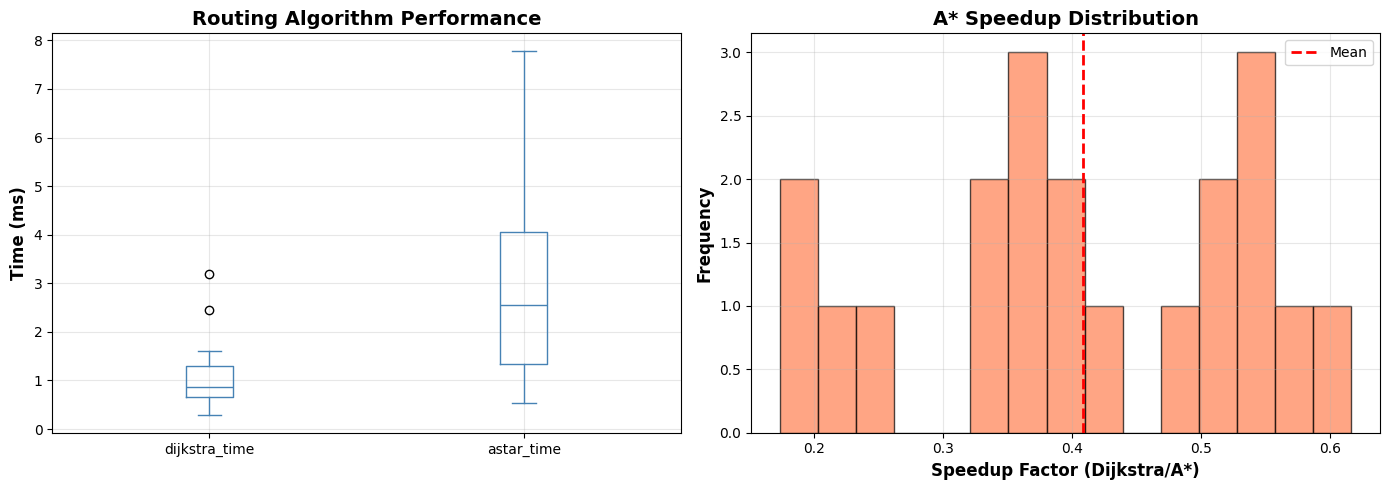

In [16]:
def benchmark_routing_algorithms(G, num_queries=20):

    results = []
    nodes = list(G.nodes())

    for i in range(num_queries):
        origin = nodes[np.random.randint(0, len(nodes))]
        dest = nodes[np.random.randint(0, len(nodes))]

        # Dijkstra
        start = time.perf_counter()
        dij_path, dij_dist = dijkstra_shortest_path(G, origin, dest, weight='length')
        dij_time = (time.perf_counter() - start) * 1000

        # A*
        start = time.perf_counter()
        astar_path, astar_dist, astar_explored = astar_shortest_path(G, origin, dest, weight='length')
        astar_time = (time.perf_counter() - start) * 1000

        results.append({
            'query': i,
            'dijkstra_time': dij_time,
            'astar_time': astar_time,
            'dijkstra_dist': dij_dist,
            'astar_dist': astar_dist,
            'astar_explored': astar_explored,
            'speedup': dij_time / astar_time if astar_time > 0 else 0
        })

    return pd.DataFrame(results)

print("\n" + "="*70)
print("BENCHMARKING ROUTING ALGORITHMS")
print("="*70)

benchmark_results = benchmark_routing_algorithms(G, num_queries=20)

print(f"\nAverage Dijkstra time: {benchmark_results['dijkstra_time'].mean():.2f} ms")
print(f"Average A* time: {benchmark_results['astar_time'].mean():.2f} ms")
print(f"Average speedup: {benchmark_results['speedup'].mean():.2f}x")
print(f"Average nodes explored by A*: {benchmark_results['astar_explored'].mean():.0f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Time comparison
benchmark_results[['dijkstra_time', 'astar_time']].plot(kind='box', ax=axes[0], color='steelblue')
axes[0].set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
axes[0].set_title('Routing Algorithm Performance', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Plot 2: Speedup distribution
axes[1].hist(benchmark_results['speedup'], bins=15, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Speedup Factor (Dijkstra/A*)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('A* Speedup Distribution', fontsize=14, fontweight='bold')
axes[1].axvline(benchmark_results['speedup'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Export results

benchmark_results.to_csv('routing_benchmark.csv', index=False)

print("\n" + "="*70)
print("ROUTE OPTIMIZATION SYSTEM COMPLETE!")
print("="*70)
print("Files generated:")
print("  - route_map.html (interactive map)")
print("  - routing_benchmark.csv (performance data)")


ROUTE OPTIMIZATION SYSTEM COMPLETE!
Files generated:
  - route_map.html (interactive map)
  - routing_benchmark.csv (performance data)
